# Data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/intro_ml/blob/main/docs/02_data.ipynb)

In [1]:
# if you're using colab, then install the required modules
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    pass

## Tensors

### NumPy

In [29]:
import numpy as np

In [10]:
np.random.normal(size=(1,))  # scalar

array([-1.54858219])

In [11]:
np.random.normal(size=(3,))  # vector

array([-1.18848916,  0.04164453,  1.60673605])

In [12]:
np.random.normal(size=(3, 3))  # matrix

array([[ 0.25626228,  0.27235102,  0.76194289],
       [-1.61710327,  0.60670584,  0.72050976],
       [-1.31817124,  0.58772453, -0.1209499 ]])

### scikit-learn

### [TensorFlow](https://www.tensorflow.org/guide/tensor)

In [31]:
import tensorflow as tf

In [14]:
tf.random.normal(shape=(1,))  # scalar

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.29955947], dtype=float32)>

In [15]:
tf.random.normal(shape=(3,))  # vector

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.5225624 , -2.2838907 ,  0.75311697], dtype=float32)>

In [16]:
tf.random.normal(shape=(3, 3))  # matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-0.9250597 , -1.0387895 ,  0.31616974],
       [ 0.48603716,  0.14275853,  0.07815948],
       [ 1.9737301 ,  0.50876594, -1.7230648 ]], dtype=float32)>

### PyTorch

In [32]:
import torch

## Random seed

Use random seeds to make your workflow deterministic and assist reproducibility.

### NumPy

Used by scikit-learn.

In [ ]:
np.random.seed(42)

### TensorFlow

In [30]:
tf.keras.utils.set_random_seed(42)

### PyTorch

(logits_and_log_odds)=
## Logits and Log-odds

[Logits](https://developers.google.com/machine-learning/glossary#logits) are a vector of raw (non-normalised) predictions from a classification model. For multi-class classification, these are converted to (normalised) probabilities using a softmax function.

[Log-odds](https://developers.google.com/machine-learning/glossary#log-odds) are the logarithm of the odds of an event. They're the inverse of the sigmoid function.

### TensorFlow

## Data pipelines

The data pipeline can be useful:

- When the data does not fit in memory.
- When the data requires pre-processing.
- To efficiently use hardware.

The steps can include:

- Extract e.g., read data from memory / storage.
- Transform e.g., pre-processing, batching, shuffling.
- Load e.g., transfer to GPU.

### Data loading

[Keras](https://keras.io/api/data_loading/) models accept three types of inputs:

- [NumPy arrays](https://www.tensorflow.org/guide/data#consuming_numpy_arrays)
    - Suitable for when the data fits in memory.
- [TensorFlow Dataset objects](https://www.tensorflow.org/guide/data#dataset_structure)
    - Suitable for datasets that do not fit in memory and that are streamed from disk or from a distributed filesystem.
- [Python generators](https://www.tensorflow.org/guide/data#consuming_python_generators)
    - Suitable for custom processing yielding batches of data (subclasses of `tf.keras.utils.Sequence` class).

If you have a large dataset and you are training on GPU(s), consider using `Dataset` objects, since they will take care of performance-critical details, such as:

- Asynchronously preprocessing your data on CPU while your GPU is busy, and buffering it into a queue.
- Prefetching data on GPU memory so it's immediately available when the GPU has finished processing the previous batch, so you can reach full GPU utilization.

Keras features a range of utilities to help you turn raw data on disk into a Dataset:

- [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) turns image files sorted into class-specific folders into a labeled dataset of image tensors.
- [`tf.keras.utils.text_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory) does the same for text files.
- [`tf.keras.utils.timeseries_dataset_from_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) creates a dataset of sliding windows over a timeseries provided as array.

"step fusing"

model = build_model()
model.compile(
    optimiser,
    loss,
    steps_per_execution=32  # this step
)
model.fit(dataset, epochs=epochs, callbacks=callbacks)

#### TensorFlow

In [21]:
# first load the mnist data
(x_train_tf, y_train_tf), (x_test_tf, y_test_tf) = tf.keras.datasets.mnist.load_data()
x_train_tf, x_test_tf = x_train_tf / 255.0, x_test_tf / 255.0  # normalise

# add a channels dimension
x_train_tf = x_train_tf[..., tf.newaxis].astype("float32")
x_test_tf = x_test_tf[..., tf.newaxis].astype("float32")

Convert to a TensorFlow object:

In [22]:
train_ds_tf = tf.data.Dataset.from_tensor_slices((x_train_tf, y_train_tf))
test_ds_tf = tf.data.Dataset.from_tensor_slices((x_test_tf, y_test_tf))

In [23]:
train_ds_tf

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

### Shuffle

Shuffle the training data.

#### TensorFlow

In [25]:
train_ds_tf = train_ds_tf.shuffle(10000)

In [26]:
train_ds_tf

<ShuffleDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

### [Batch](https://www.tensorflow.org/guide/data#batching_dataset_elements)

A batch is a set of examples used in one iteration of model training.

The batch size is the number of examples in a batch.

#### TensorFlow

In [27]:
train_ds_tf = train_ds_tf.batch(batch_size=32)
test_ds_tf = test_ds_tf.batch(batch_size=32)

In [28]:
train_ds_tf

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

### [Map](https://www.tensorflow.org/guide/data#preprocessing_data)

Map a preprocessing function to a dataset.

#### TensorFlow

```python
dataset.map(function)
```

There are range of ways to [improve the performance](https://www.tensorflow.org/guide/data_performance) of the data pipeline.

In these examples, using `tf.data.AUTOTUNE` leaves the decision to TensorFlow.

(cache_prefetch)=
### [Dataset caching](https://www.tensorflow.org/guide/data_performance#caching)

Cache the data after the first iteration through it. The data can be cached to either memory or a local file.

This can improve performance when:

- The data is the same each iteration.
- The data is read from a remote distributed filesystem.
- The data is I/O (input/output) bound and will fit in memory.

#### TensorFlow

```python
dataset.cache()
```

### [Prefetch data](https://www.tensorflow.org/guide/data_performance#prefetching)

Prefect the next batch to save time waiting for it.

#### TensorFlow

```python
dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
```

### [Parallel data extraction](https://www.tensorflow.org/guide/data_performance#parallelizing_data_extraction)

Extract the data in parallel.

#### TensorFlow

```python
dataset.interleave(
    build_dataset, 
    num_parallel_calls=tf.data.AUTOTUNE
)
```

###  [Parallel data transformation](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation)

Pre-process your data in parallel.

#### TensorFlow

```python
dataset.map(
    function, 
    num_parallel_calls=tf.data.AUTOTUNE
)
```

### [Vectorise mapping](https://www.tensorflow.org/guide/data_performance#vectorizing_mapping)

Batch _before_ mapping, to vectorise a function.

#### TensorFlow

```python
dataset.batch(256).map(function)
```

jit compile

model = build_model()
model.compile(
    optimiser,
    loss,
    jit_compile=True  # this step
)
model.fit(dataset, epochs=epochs, callbacks=callbacks)

## Data preprocessing

- Tokenization of string data, followed by token indexing.
- Feature normalization.
- Rescaling the data to small values (in general, input values to a neural network should be close to zero -- typically we expect either data with zero-mean and unit-variance, or data in the [0, 1] range.


### [Mixed precision](https://www.tensorflow.org/guide/mixed_precision)

Mixed precision is the use of 16-bit and 32-bit floating-point types during training to use less memory and make it run faster.

#### TensorFlow

```python
tf.keras.mixed_precision.set_global_policy('mixed_float16')
```

```{note}
This functionality varies by GPU, and is mostly available to modern NVIDIA GPUs.
```

```{warning}
Be careful with underflow and overflow issues.

16-bit floats above 65504 overflow to infinity and below 6.0<sub>x10</sub><sup>-8</sup> underflow to zero.

[Loss scaling](https://www.tensorflow.org/guide/mixed_precision#loss_scaling_overview) can help avoid errors by scaling the losses up or down temporarily i.e.,:  
`optimizer = mixed_precision.LossScaleOptimizer(optimizer)`  

```

In [ ]:
import numpy as np
import tensorflow as tf
import torch

- datasets
- data centric AI hub videos
- efficient feeding of data into GPUs
- pipelines for large data I/O into GPUs using compression/decompression, Ray datasets




## TensorFlow Datasets

...

(data_augmentation)=
## [Data augmentation](https://youtu.be/JI8saFjK84o)

Artificially increasing the range and number of training examples.

Useful for small data sets.

There are a range of methods. For example, in image problems you could rotate, stretch, and reflect images.

### Synthetic data

...

- [NVIDIA Replicator Composer](https://docs.omniverse.nvidia.com/app_isaacsim/app_isaacsim/tutorial_replicator_composer.html#replicator-composer)

## Example - Digit Classification

### TensorFlow

In [39]:
import tensorflow as tf

In [40]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


In [93]:
tf.keras.utils.set_random_seed(42)

In [94]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

Create the model usin the [Functional API](https://keras.io/guides/functional_api/):

In [95]:
inputs = tf.keras.Input(shape=(28, 28), name="inputs")
x = tf.keras.layers.Flatten(name="flatten")(inputs)
x = tf.keras.layers.Rescaling(1.0 / 255, name="normalise")(x)
x = tf.keras.layers.Dense(128, activation="relu", name="layer1")(x)
x = tf.keras.layers.Dense(128, activation="relu", name="layer2")(x)
outputs = tf.keras.layers.Dense(10, name="outputs")(x)

model = tf.keras.Model(inputs, outputs, name="functional")

model.summary()

Model: "functional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 normalise (Rescaling)       (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 outputs (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trai

In [96]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [97]:
epochs = 10

history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=64,
    verbose=False,
    validation_split=0.2,
);

In [98]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

View the loss and accuracy curves over the epochs:

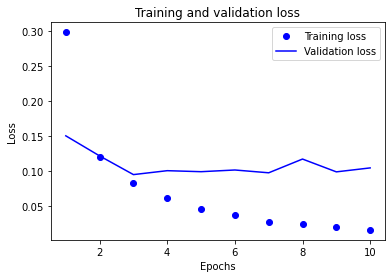

In [99]:
plt.plot(epochs_range, history.history["loss"], "bo", label="Training loss")
plt.plot(epochs_range, history.history["val_loss"], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

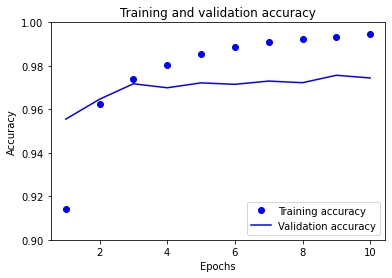

In [100]:
plt.plot(epochs_range, history.history["accuracy"], "bo", label="Training accuracy")
plt.plot(
    epochs_range, history.history["val_accuracy"], "b", label="Validation accuracy"
)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.9, 1.0])
plt.legend()
plt.show()

The training accuracy and the validation accuracy are diverging.

The model is overfitting (i.e., doing too well on the training data compared to the validation data).

One way to alleviate this is to [add weight regularisation](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization).

In this example, we'll add [dropout](overfit) to the dense layers.

In [113]:
inputs = tf.keras.Input(shape=(28, 28), name="inputs")
x = tf.keras.layers.Flatten(name="flatten")(inputs)
x = tf.keras.layers.Rescaling(1.0 / 255, name="normalise")(x)
x = tf.keras.layers.Dense(
    128,
    activation="relu",
    name="layer1",
)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(
    128,
    activation="relu",
    name="layer2",
)(x)
outputs = tf.keras.layers.Dense(10, name="outputs")(x)

model = tf.keras.Model(inputs, outputs, name="functional")

In [114]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [115]:
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=64,
    verbose=False,
    validation_split=0.2,
);

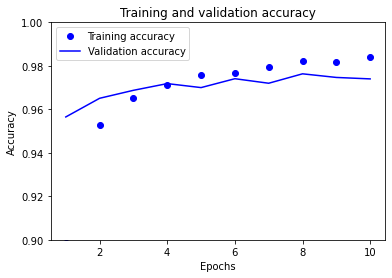

In [116]:
plt.plot(epochs_range, history.history["accuracy"], "bo", label="Training accuracy")
plt.plot(
    epochs_range, history.history["val_accuracy"], "b", label="Validation accuracy"
)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.9, 1.0])
plt.legend()
plt.show()

## Exercises

```{admonition} Exercise 1

...

```

## {ref}`Solutions <data>`

## Key Points

```{important}

- [x] _Use a data pipeline._
- [x] _Optimise the data pipeline with caching, prefetching, parallel extraction, parallel preprocessing, and vectorised mapping._

```

## Further information

### Good practices

- Do data processing as part of the model to increase portability and reproducibility.
- Analyse data pipeline performance with [TensorBoard Profiler](https://www.tensorflow.org/guide/data_performance_analysis).
- Use sparse tensors when there are many zeros / np.nans (e.g., [TensorFlow](https://www.tensorflow.org/guide/sparse_tensor)).
- Take care with [datasets with imbalanced classes](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset) (i.e., only a few positive samples).


### Other options

- ...
 
### Resources

#### General

- [Papers with code - Datasets](https://paperswithcode.com/datasets)
- [HuggingFace - Datasets](https://huggingface.co/datasets)
- [Google research datasets](https://ai.google/tools/datasets/)
- [Google Dataset Search](https://datasetsearch.research.google.com/)
- [Google Cloud public datasets](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset&pli=1)
- [Kaggle Datasets](https://www.kaggle.com/datasets)

#### TensorFlow

- [TensorFlow official datasets](https://www.tensorflow.org/datasets)

#### PyTorch

- [Torch Vision Datasets](https://pytorch.org/vision/stable/datasets.html)
- [Torch Text Datasets](https://pytorch.org/text/stable/datasets.html)
- [Torch Audio Datasets](https://pytorch.org/audio/stable/datasets.html)